In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

train_meta = pd.read_csv("/content/drive/MyDrive/birdclef-2023/train_metadata.csv")
total_data_count = len(train_meta)
print("There are a total of ", total_data_count, "  entries in the dataset")
print("Here is the first entry in the dataset metadata:\n")
print(train_meta.iloc[0])


There are a total of  16941   entries in the dataset
Here is the first entry in the dataset metadata:

primary_label                                                 abethr1
secondary_labels                                                   []
type                                                         ['song']
latitude                                                       4.3906
longitude                                                     38.2788
scientific_name                                    Turdus tephronotus
common_name                                  African Bare-eyed Thrush
author                                                  Rolf A. de By
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            4.0
url                                 https://www.xeno-canto.org/128013
filename                                         abethr1/XC128013.ogg
Name: 0, dtype: object


In [ ]:

labels = list(train_meta['primary_label'].unique())
print("There are ", len(labels), " different labels in the whole dataset.\n")
num_birds = len(labels)
epochs = 2

num_birds = 9 
labels = labels[0:num_birds]
print("To speed things up, we are only using ", len(labels), " different labels (or birds).\n")
epochs = 5 

There are  264  different labels in the whole dataset.

To speed things up, we are only using  9  different labels (or birds).



In [ ]:
image_data = []
for label in labels : 
    image_data.append(train_meta[train_meta["primary_label"] == label].iloc[:])
image_data = pd.concat(image_data).reset_index(drop=True) 
total_image_data_count = len(image_data)
print("There are ", total_image_data_count, " different entries in the image data set.\n")

There are  436  different entries in the image data set.



In [ ]:

import librosa 
import numpy as np
from PIL import Image
import os
import soundfile as sf

use_mfcc = False 
n_mels = 64 
n_coeff = 64 


if use_mfcc :
    if n_coeff < n_mels :
        num_rows = n_coeff 
    else :
        num_rows = n_mels
else :
    num_rows = n_mels
num_columns = 313 
num_channels = 1

sr = 32000 

Window_Size = 5 
segment = Window_Size * sr


def Audio_to_Domain(y, sr):
    if use_mfcc:
        feat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_coeff, n_mels=n_mels, power=3) 
    else :
        feat = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, power=1)
    if feat.shape[1] <= num_columns:
        pad_width = num_columns - feat.shape[1]
        feat = np.pad(feat, pad_width=((0,0),(0,pad_width)), mode='constant')
    return feat

def Domain_to_Audio(feat, sr):
    if use_mfcc :
        y = librosa.feature.inverse.mfcc_to_audio(feat, sr=sr, n_mels=n_mels, power=3)
    else :
        y = librosa.feature.inverse.mel_to_audio(feat, sr=sr, power=1) 
    return y


def Audio_Segment_Transform_and_Save(file_path, cat_name='dummy', is_save=True, train=True, sr=sr):

    
    filename = file_path.replace("/", "_")
    file_path = "/content/drive/MyDrive/birdclef-2023/train_audio/" + file_path
    audio, sr = librosa.load(file_path, sr = sr)

    buffer = segment

    samples_total = len(audio)
    samples_wrote = 0
    counter = 1

    feature_split = []
    feature_filenames = []
    feature_mins = []
    feature_ranges = []
    while samples_wrote < samples_total:
        if buffer > (samples_total - samples_wrote):
            buffer = samples_total - samples_wrote

        block = audio[samples_wrote : (samples_wrote + buffer)]
        these_features = Audio_to_Domain(block, sr)
        feature_split.append(these_features)

        if is_save == True:
            out_filename = "/content/drive/MyDrive/zimages/" + cat_name + \
                "/split_" + str(counter) + "_" + filename + ".png"
            
            feature_filenames.append(out_filename)
            
            fmax = these_features.max()
            fmin = these_features.min()
            frange = fmax - fmin
            these_features = np.array((((these_features - fmin) / frange)*255), dtype='uint8')
            feature_mins.append(fmin)
            feature_ranges.append(frange)
            this_image = Image.fromarray(these_features, mode = 'L')
            if not os.path.exists(os.path.dirname(out_filename)):
                try:
                    os.makedirs(os.path.dirname(out_filename))
                except OSError as exc: 
                    if exc.errno != errno.EEXIST:
                        raise  
            this_image.save(out_filename, format="PNG")
            
        counter += 1
        samples_wrote += buffer
    return feature_split, sr, feature_filenames, feature_mins, feature_ranges

def Load_and_UnTransform(filename):
    this_image = Image.open(filename)
    block = Domain_to_Audio(this_image, sr)
    return block, sr
    

def Save_Features(_df, train=True):
    data = []

    if os.path.exists(os.path.dirname("//content/drive/MyDrive/zimages/")):
        print("WARNING: Image files already saved. Aborting save to avoid corrupted image databse.")
        data_df = pd.DataFrame(data, columns=['primary_label', 'original_filename', 'filename', 'fmin', 'frange'])
        data_df = pd.read_csv("/content/drive/MyDrive/zimages.csv")
    else:
        for index, row in _df.iterrows(): 
            audio_lst, sr, filenames, mins, ranges = Audio_Segment_Transform_and_Save(row["filename"], cat_name = row["primary_label"], is_save = True, train = train)
            for idx, y in enumerate(audio_lst):
                data.append([row["primary_label"], row["filename"], filenames[idx], mins[idx], ranges[idx]])
    
        data_df = pd.DataFrame(data, columns=['primary_label', 'original_filename', 'filename', 'fmin', 'frange'])
        data_df.to_csv("/content/drive/MyDrive/zimages.csv", index=False)

    return data_df
    
    


In [ ]:

import IPython
import matplotlib.pyplot as plt

def Compare_Feature_Extraction(image_data, list_to_compare) :
    global sr, segment
    list_len = len(list_to_compare)
    if list_len < 2 :
        print("Must provide at least 2 items - cannot compare.\n")
        return()
    else:
        plt.figure(figsize=(10, 10))
        for i in range(list_len):
            audio_filename = image_data.at[list_to_compare[i],"filename"]
            common_name = image_data.at[list_to_compare[i],"common_name"]
            audio, sr = librosa.load("/content/drive/MyDrive/birdclef-2023/train_audio/" + audio_filename, sr = sr)
            audio = audio[0:segment]
            feat = Audio_to_Domain(audio, sr)
            fmin = feat.min()
            fmax = feat.max()
            frange = fmax - fmin
            feat = np.array((((feat - fmin) / frange)*255), dtype='uint8')
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(feat, cmap='gray', aspect=(num_columns/num_rows), interpolation = 'None')
            plt.title(common_name)
            plt.axis("off")
    return()


In [ ]:

use_mfcc = False 
n_mels = 16 
n_coeff = 1 


if use_mfcc :
    if n_coeff < n_mels :
        num_rows = n_coeff 
    else :
        num_rows = n_mels
else :
    num_rows = n_mels

Compare features from the SAME birds (first 5 sec of audio used)



()

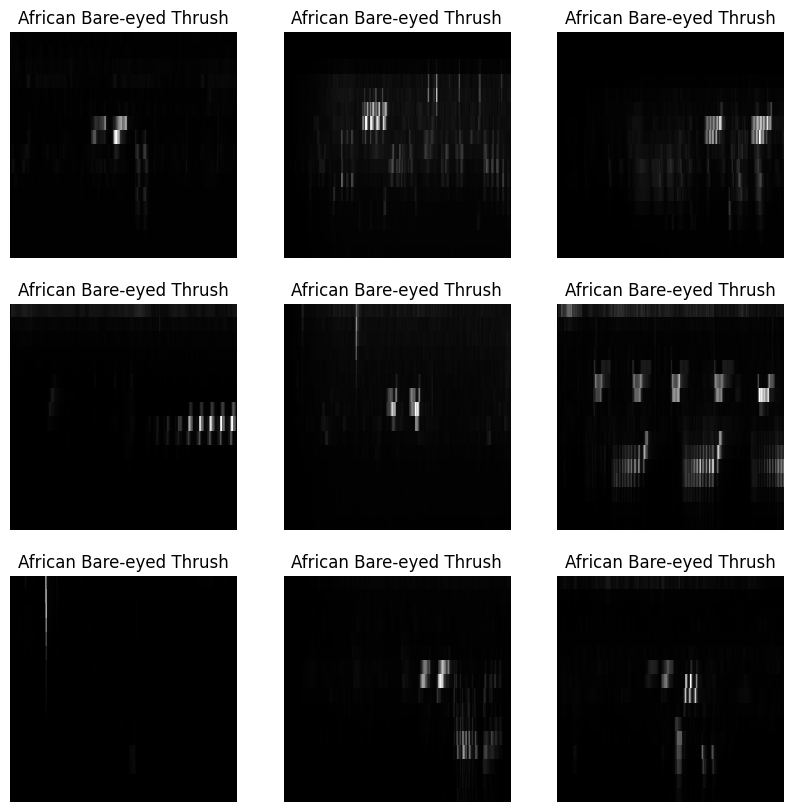

In [ ]:
print("Compare features from the SAME birds (first 5 sec of audio used)\n")    
Compare_Feature_Extraction(image_data, [0, 1, 2, 3, 4, 5, 6, 7, 8])

Compare features from the DIFFERENT birds (first 5 sec of audio used)



()

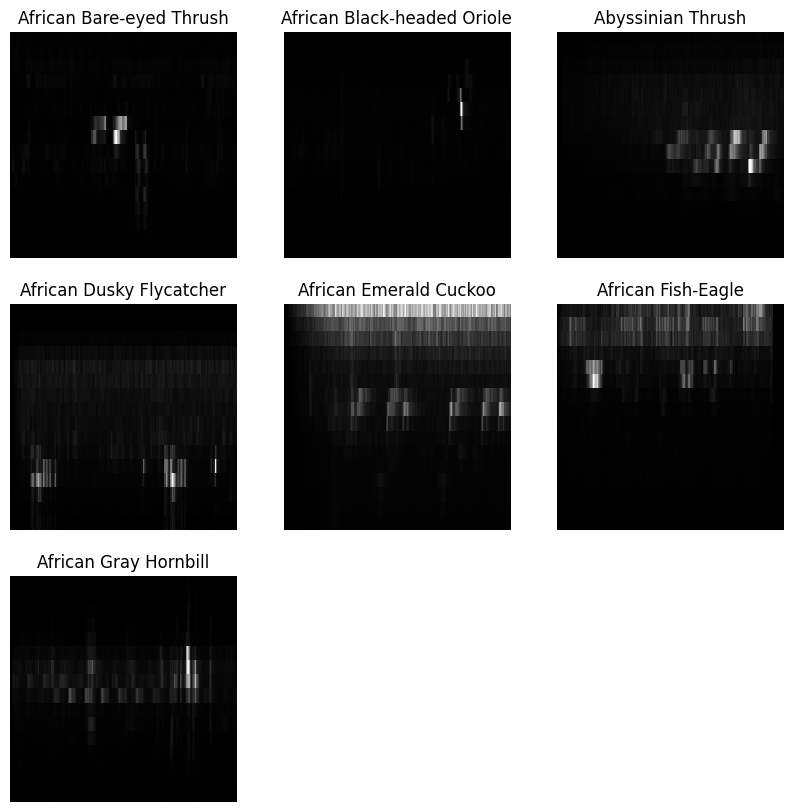

In [ ]:
print("Compare features from the DIFFERENT birds (first 5 sec of audio used)\n")   
Compare_Feature_Extraction(image_data, [0, 50, 150, 200, 225, 350, 430])

In BLUE is the original audio of the first segment of the first audio file

Superimposed in ORANGE the RECREATED (un-transformed) audio of the first segment of the first image file

This is the audio playback of the ORIGINAL audio file


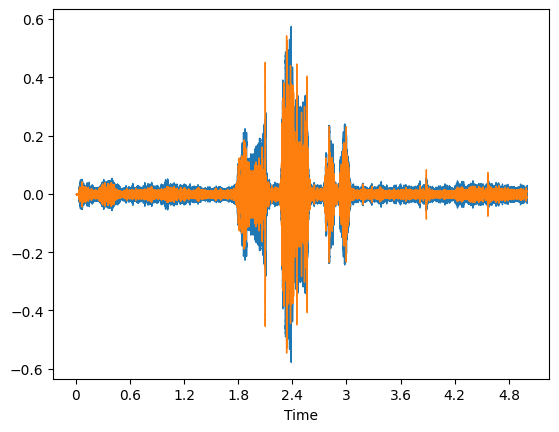

In [ ]:
audio_filename = image_data.at[0,"filename"]
common_name = image_data.at[0,"common_name"]

audio, sr = librosa.load("/content/drive/MyDrive/birdclef-2023/train_audio/" + audio_filename, sr = sr)

audio = audio[0:segment]
feat = Audio_to_Domain(audio, sr)
fmin = feat.min()
fmax = feat.max()
frange = fmax - fmin
feat = np.array((((feat - fmin) / frange)*255), dtype='uint8')
feat = ((feat/255)*frange)+fmin
recreated_audio = Domain_to_Audio(feat, sr)

print("In BLUE is the original audio of the first segment of the first audio file\n")
librosa.display.waveshow(audio, sr=sr)

print("Superimposed in ORANGE the RECREATED (un-transformed) audio of the first segment of the first image file\n")
librosa.display.waveshow(recreated_audio, sr=sr)

print("This is the audio playback of the ORIGINAL audio file")
IPython.display.Audio(data = audio, rate=sr)

In [ ]:
print("This is the audio playback of the RECREATED audio file")
IPython.display.Audio(data = recreated_audio, rate=sr)

This is the audio playback of the RECREATED audio file


In [ ]:

use_mfcc = True 
n_mels = 64 
n_coeff = 16 


if use_mfcc :
    if n_coeff < n_mels :
        num_rows = n_coeff 
    else :
        num_rows = n_mels
else :
    num_rows = n_mels
    

Compare features from the SAME birds (first 5 sec of audio used)



()

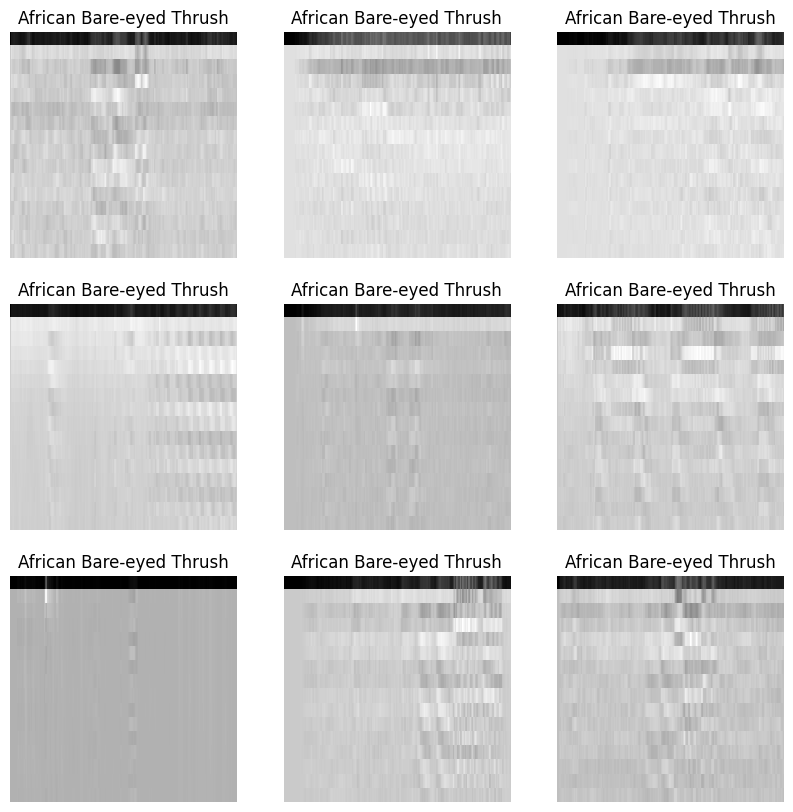

In [ ]:
print("Compare features from the SAME birds (first 5 sec of audio used)\n") 
Compare_Feature_Extraction(image_data, [0, 1, 2, 3, 4, 5, 6, 7, 8])

Compare features from the DIFFERENT birds (first 5 sec of audio used)



()

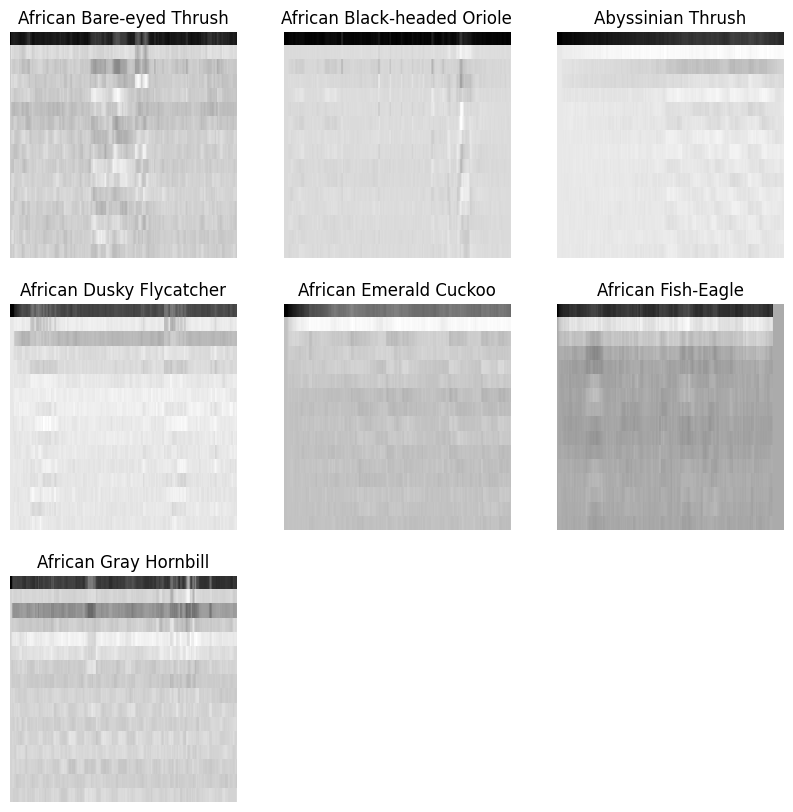

In [ ]:
print("Compare features from the DIFFERENT birds (first 5 sec of audio used)\n")            
# Compare the first 10 entries in the image_data
Compare_Feature_Extraction(image_data, [0, 50, 150, 200, 225, 350, 430])

In BLUE is the original audio of the first segment of the first audio file

Superimposed in ORANGE the RECREATED (un-transformed) audio of the first segment of the first image file

This is the audio playback of the ORIGINAL audio file


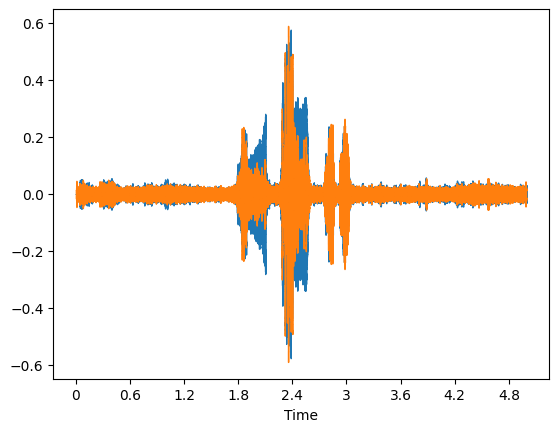

In [ ]:
audio_filename = image_data.at[0,"filename"]
common_name = image_data.at[0,"common_name"]

audio, sr = librosa.load("/content/drive/MyDrive/birdclef-2023/train_audio/" + audio_filename, sr = sr)

audio = audio[0:segment]
feat = Audio_to_Domain(audio, sr)
fmin = feat.min()
fmax = feat.max()
frange = fmax - fmin
feat = np.array((((feat - fmin) / frange)*255), dtype='uint8')
feat = ((feat/255)*frange)+fmin
recreated_audio = Domain_to_Audio(feat, sr)

print("In BLUE is the original audio of the first segment of the first audio file\n")
librosa.display.waveshow(audio, sr=sr)

print("Superimposed in ORANGE the RECREATED (un-transformed) audio of the first segment of the first image file\n")
librosa.display.waveshow(recreated_audio, sr=sr)

print("This is the audio playback of the ORIGINAL audio file")
IPython.display.Audio(data = audio, rate=sr)

In [ ]:

use_mfcc = False 
n_mels = 32 
n_coeff = 1 


if use_mfcc :
    if n_coeff < n_mels :
        num_rows = n_coeff 
    else :
        num_rows = n_mels
else :
    num_rows = n_mels

Compare features from the SAME birds (first 5 sec of audio used)



()

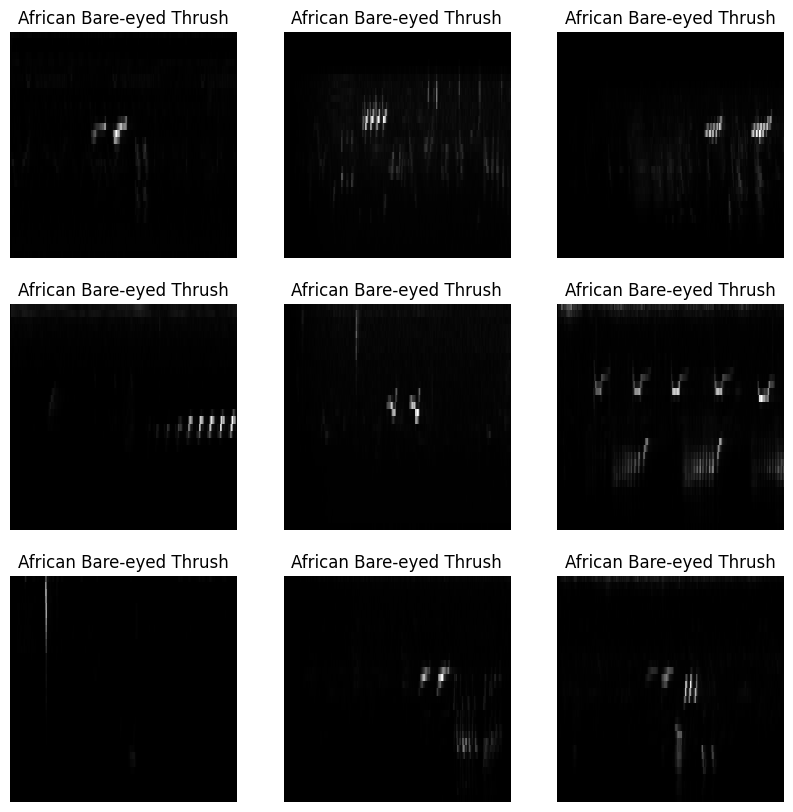

In [ ]:
print("Compare features from the SAME birds (first 5 sec of audio used)\n") 
Compare_Feature_Extraction(image_data, [0, 1, 2, 3, 4, 5, 6, 7, 8])

Compare features from the DIFFERENT birds (first 5 sec of audio used)



()

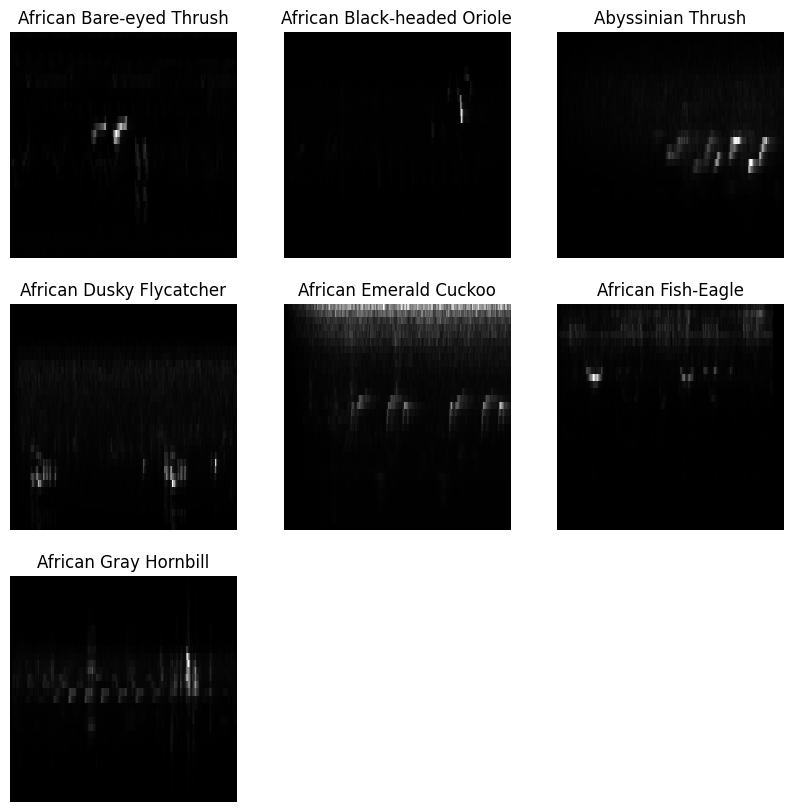

In [ ]:
print("Compare features from the DIFFERENT birds (first 5 sec of audio used)\n")            
Compare_Feature_Extraction(image_data, [0, 50, 150, 200, 225, 350, 430])

In BLUE is the original audio of the first segment of the first audio file

Superimposed in ORANGE the RECREATED (un-transformed) audio of the first segment of the first image file

This is the audio playback of the ORIGINAL audio file


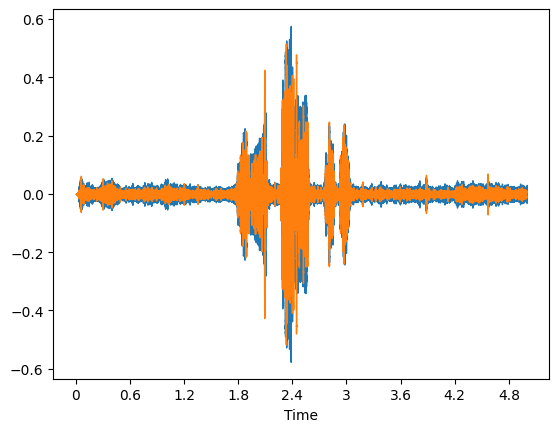

In [ ]:
audio_filename = image_data.at[0,"filename"]
common_name = image_data.at[0,"common_name"]

audio, sr = librosa.load("/content/drive/MyDrive/birdclef-2023/train_audio/" + audio_filename, sr = sr)

audio = audio[0:segment]
feat = Audio_to_Domain(audio, sr)
fmin = feat.min()
fmax = feat.max()
frange = fmax - fmin
feat = np.array((((feat - fmin) / frange)*255), dtype='uint8')
feat = ((feat/255)*frange)+fmin
recreated_audio = Domain_to_Audio(feat, sr)

print("In BLUE is the original audio of the first segment of the first audio file\n")
librosa.display.waveshow(audio, sr=sr)

print("Superimposed in ORANGE the RECREATED (un-transformed) audio of the first segment of the first image file\n")
librosa.display.waveshow(recreated_audio, sr=sr)

print("This is the audio playback of the ORIGINAL audio file")
IPython.display.Audio(data = audio, rate=sr)

In [ ]:
print("This is the audio playback of the RECREATED audio file")
IPython.display.Audio(data = recreated_audio, rate=sr)

This is the audio playback of the RECREATED audio file


In [ ]:
import time 

def Save_Image_Examples():
    global image_df, n_mels, n_coeff, use_mfcc, num_rows
    
    if use_mfcc :
        if n_coeff < n_mels :
            num_rows = n_coeff 
        else :
            num_rows = n_mels
    else :
        num_rows = n_mels

    print("Starting to save Images. Please wait...\n")
    start_time = time.time()
    image_df = Save_Features(image_data, train=True)
    end_time = time.time()
    print("Total amount of time to convert and save image data is ", (end_time - start_time), 
          " seconds\n")
    return

In [ ]:
print("There are ", total_image_data_count, " different entries in the audio files data set.\n")
Save_Image_Examples()

There are  436  different entries in the audio files data set.

Starting to save Images. Please wait...

Total amount of time to convert and save image data is  0.22719788551330566  seconds



In [ ]:
import PIL
transformed_file = image_df.at[0,"filename"]
original_file = image_df.at[0,"original_filename"]

trans_1 = PIL.Image.open(transformed_file)
print("Shape of loaded image  ", trans_1.height, trans_1.width)
audio_1, sr = librosa.load("/content/drive/MyDrive/birdclef-2023/train_audio/" + original_file, sr = sr)

audio_1 = audio_1[0:segment]

Shape of loaded image   32 313


This is the original audio, (segmented but not transformed) visually displayed as a graphic file


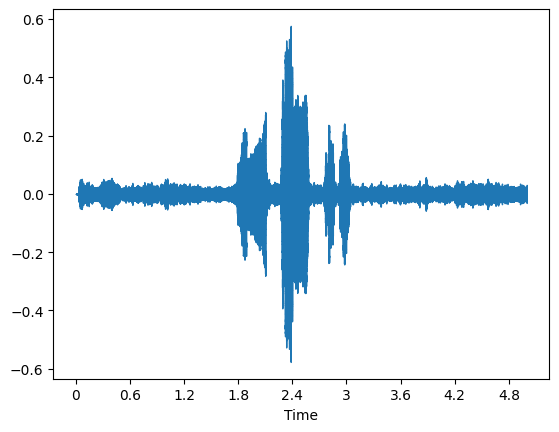

In [ ]:
print("This is the original audio, (segmented but not transformed) visually displayed as a graphic file")
librosa.display.waveshow(audio_1, sr=sr)

In [ ]:
import IPython

IPython.display.Audio(data = audio_1, rate=sr)

Shape of loaded image (height and width) 32 313
Graphic of loaded image file
Here is the image file that was loaded



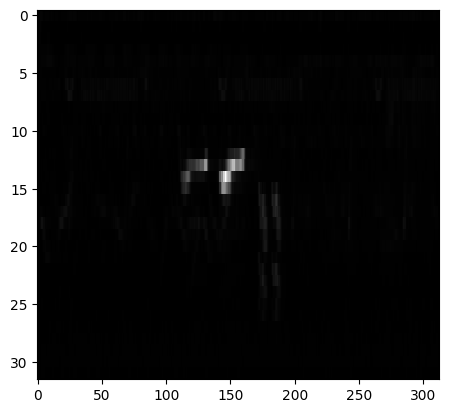

In [ ]:
print("Shape of loaded image (height and width)", trans_1.height, trans_1.width)
print("Graphic of loaded image file")
print("Here is the image file that was loaded\n")
plt.imshow(trans_1, cmap='gray', aspect=int(num_columns/num_rows) , interpolation = 'None')
plt.show() 

shape of image array: (32, 313)
Before scaling, image has values within this range:  0 255
After scaling, normalized transform has values within this range:  0.00015478507 2.39211728507
This is the recreated audio, (un-transformed) visually displayed as a graphic file


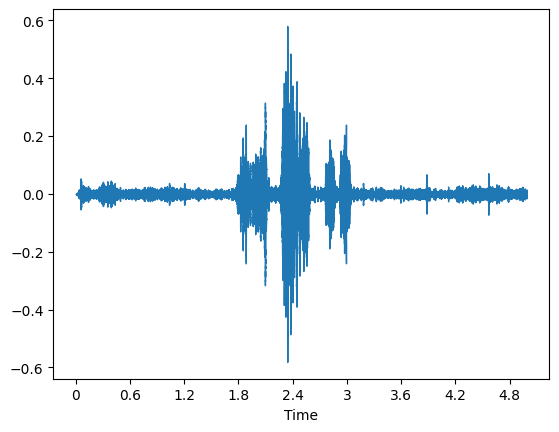

In [ ]:

norm_trans = np.array(trans_1)
print("shape of image array:", norm_trans.shape)
print("Before scaling, image has values within this range: ", norm_trans.min(), norm_trans.max())
rescale_factor = image_df.at[0,"frange"]/255
rescale_shift = image_df.at[0,"fmin"]
norm_trans = (norm_trans * rescale_factor) + rescale_shift

print("After scaling, normalized transform has values within this range: ", norm_trans.min(), norm_trans.max())
untrans_1 = Domain_to_Audio(norm_trans, sr)
print("This is the recreated audio, (un-transformed) visually displayed as a graphic file")
librosa.display.waveshow(untrans_1, sr=sr)

In [ ]:
IPython.display.Audio(data = untrans_1, rate=sr)

In [ ]:
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Concatenate, Activation
from keras.layers import Dropout,BatchNormalization, Input, Rescaling

inputs = Input(shape = (num_rows, num_columns, 1))

model = Rescaling(1./255)(inputs)

model1 = Conv2D(filters=16, kernel_size=(3, 3), padding='SAME', activation='relu')(model)   
model1 = Conv2D(filters=16, kernel_size=(3, 3), padding='SAME', activation='relu')(model1)  
model1 = MaxPool2D(pool_size=(2, 2))(model1)

model1a = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model1) 
model1a = Dropout(0.2)(model1a)
model1a = Conv2D(filters=16, kernel_size=(3, 3), padding='SAME', activation='relu')(model1a)
model1a = Dropout(0.2)(model1a)

model1b = Conv2D(filters=16, kernel_size=(3, 3), padding='SAME', activation='relu')(model1a)
model1b = Conv2D(filters=16, kernel_size=(3, 3), padding='SAME', activation='relu')(model1b)

model1b = MaxPool2D(pool_size=(2, 2))(model1b)

model1c = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model1b)

model1c = Flatten()(model1c)
model1c = Dense(64, activation = "relu")(model1c)

bird_classification = Dense(num_birds, activation = 'softmax')(model1c)

model = Model(inputs=inputs, outputs=bird_classification)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 313, 1)]      0         
                                                                 
 rescaling (Rescaling)       (None, 32, 313, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 32, 313, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 313, 16)       2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 156, 16)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 156, 32)       12832     
                                                             

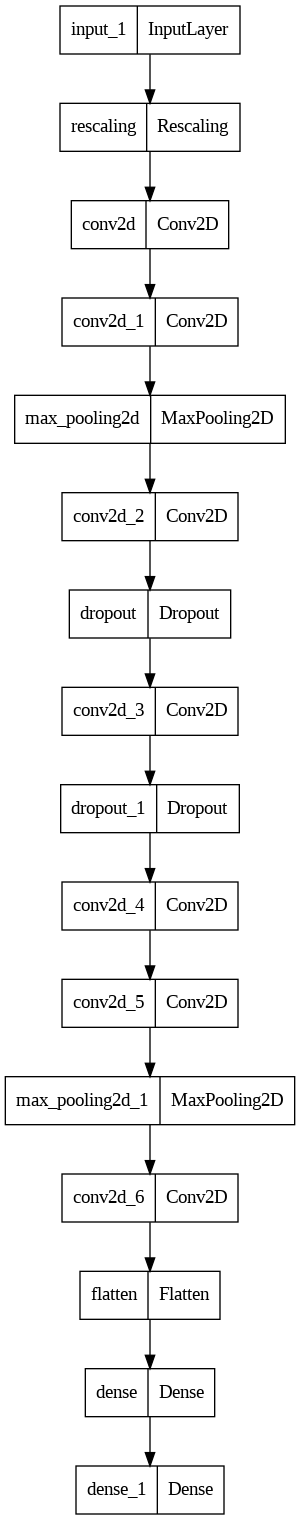

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

batch_size = 256 

img_height = num_rows
img_width = num_columns

print("Use dataset_from_directory to gather training images.\n")
train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/zimages/",
  validation_split=0.2,
  subset="training",
  seed=111,    
  image_size=(img_height, img_width),
  color_mode = "grayscale",
  label_mode = 'categorical',
  batch_size=batch_size)

print("\nClass names for training are: ", train_ds.class_names)

print("\nUse dataset_from_directory to gather validation images.\n")
val_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/zimages/",
  validation_split=0.2,
  subset="validation",
  seed=111,
  image_size=(img_height, img_width),
  color_mode = "grayscale",
  label_mode = 'categorical',
  batch_size=batch_size)
print("\nClass names for validation are: ", val_ds.class_names)


Use dataset_from_directory to gather training images.

Found 3277 files belonging to 9 classes.
Using 2622 files for training.

Class names for training are:  ['abethr1', 'abhori1', 'abythr1', 'afbfly1', 'afdfly1', 'afecuc1', 'affeag1', 'afgfly1', 'afghor1']

Use dataset_from_directory to gather validation images.

Found 3277 files belonging to 9 classes.
Using 655 files for validation.

Class names for validation are:  ['abethr1', 'abhori1', 'abythr1', 'afbfly1', 'afdfly1', 'afecuc1', 'affeag1', 'afgfly1', 'afghor1']


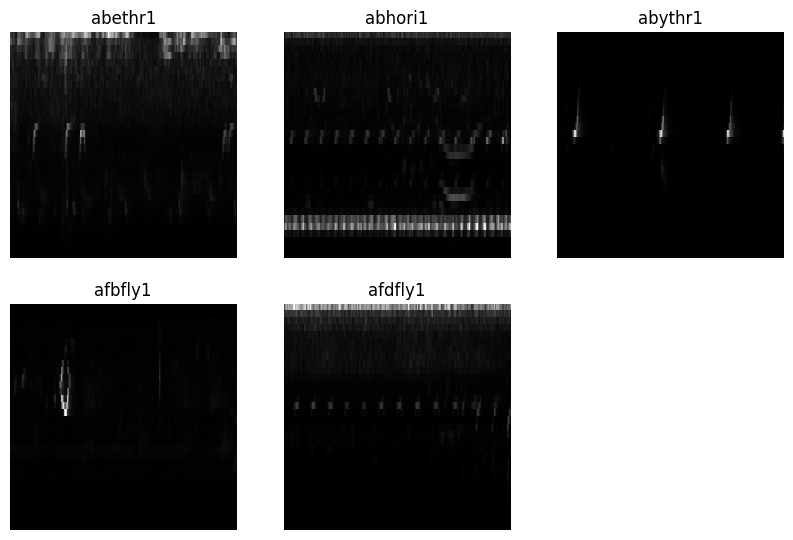

In [ ]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray', aspect=(num_columns/num_rows), interpolation = 'None')
    plt.title(class_names[i])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_model_path = "/content/drive/MyDrive/zclassifier"
metric = "val_accuracy"

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath=checkpoint_model_path,
    monitor=metric, verbose=1, save_best_only=True)
es_callback = EarlyStopping(monitor=metric, patience=5, verbose=1)

history = model.fit(
    train_ds, 
    validation_data=val_ds,
    callbacks=[checkpointer,es_callback],
    verbose = 1, 
    epochs = epochs
)


Epoch 1/5
11/11 [==============================] - ETA: 0s - loss: 1.9713 - accuracy: 0.3284
Epoch 1: val_accuracy improved from -inf to 0.34962, saving model to /content/drive/MyDrive/zclassifier


11/11 [==============================] - 122s 10s/step - loss: 1.9713 - accuracy: 0.3284 - val_loss: 1.8214 - val_accuracy: 0.3496
Epoch 2/5
10/11 [==========================>...] - ETA: 0s - loss: 1.7817 - accuracy: 0.3402
Epoch 2: val_accuracy improved from 0.34962 to 0.39389, saving model to /content/drive/MyDrive/zclassifier


11/11 [==============================] - 3s 302ms/step - loss: 1.7793 - accuracy: 0.3429 - val_loss: 1.7237 - val_accuracy: 0.3939
Epoch 3/5
10/11 [==========================>...] - ETA: 0s - loss: 1.6284 - accuracy: 0.4309
Epoch 3: val_accuracy improved from 0.39389 to 0.47634, saving model to /content/drive/MyDrive/zclassifier


11/11 [==============================] - 3s 304ms/step - loss: 1.6243 - accuracy: 0.4321 - val_loss: 1.5204 - val_accuracy: 0.4763
Epoch 4/5
10/11 [==========================>...] - ETA: 0s - loss: 1.3884 - accuracy: 0.5277
Epoch 4: val_accuracy improved from 0.47634 to 0.56489, saving model to /content/drive/MyDrive/zclassifier


11/11 [==============================] - 4s 384ms/step - loss: 1.3831 - accuracy: 0.5317 - val_loss: 1.3505 - val_accuracy: 0.5649
Epoch 5/5
10/11 [==========================>...] - ETA: 0s - loss: 1.1938 - accuracy: 0.6129
Epoch 5: val_accuracy improved from 0.56489 to 0.60763, saving model to /content/drive/MyDrive/zclassifier


11/11 [==============================] - 4s 347ms/step - loss: 1.1895 - accuracy: 0.6152 - val_loss: 1.2589 - val_accuracy: 0.6076


In [ ]:

model = keras.models.load_model(checkpoint_model_path)

In [ ]:
import matplotlib.pyplot as plt

def plot_his(history, _auto=False):
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    if (_auto) :
        plt.plot(history.history['mse']) 
        plt.plot(history.history['val_mse']) 
    else :
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()

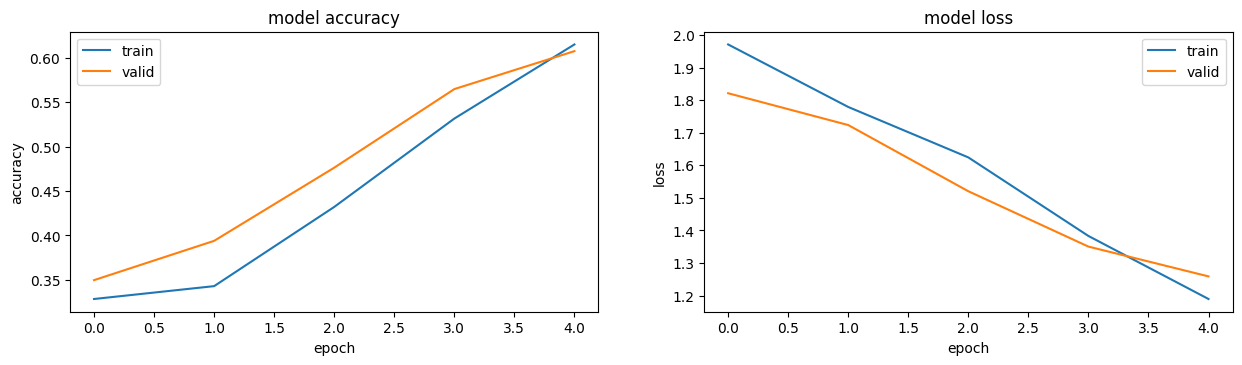

In [ ]:
plot_his(history, _auto=False)

In [ ]:
print("Let's see how the model behaves on one batch of the validation set")
batch = val_ds.take(1)
one_pred = model.predict(batch)

val_count = (len(batch))
print("Have classified ", val_count, "batch of validation images, of batch size ", batch_size)


Let's see how the model behaves on one batch of the validation set
1/1 [==============================] - 0s 132ms/step
Have classified  1 batch of validation images, of batch size  256


In [ ]:
all_correct = []
all_incorrect = []
for images, labels in val_ds.take(1):
    print("Here is the shape of one batch of validation examples\n", images.shape)
    image_square = int(np.sqrt(batch_size)) + 1
    for i in range(batch_size):
        correct = np.argmax(labels[i])
        if correct != np.argmax(one_pred[i]):
            all_incorrect.append(images[i])
        else:
            all_correct.append(images[i])
#         ax = plt.subplot(image_square, image_square, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"), cmap='gray', aspect=(num_columns/num_rows), interpolation = 'None')
#         plt.title(class_names[correct])
#         plt.axis("off")
    
# for i, j in enumerate(all_incorrect) :
#     print(i, j)
print("Total images examined ", images.shape[0])
print("Total images correctly classified ", len(all_correct))
print("Total images incorrectly classified ", len(all_incorrect))

Here is the shape of one batch of validation examples
 (256, 32, 313, 1)
Total images examined  256
Total images correctly classified  165
Total images incorrectly classified  91


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

train_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/zimages/",
  validation_split=0.2,
  subset="training",
  seed=111,    
  image_size=(img_height, img_width),
  color_mode = "grayscale",
  label_mode = 'categorical',
  batch_size=batch_size)

class_names = train_ds.class_names

val_ds = tf.keras.utils.image_dataset_from_directory(
  "/content/drive/MyDrive/zimages/",
  validation_split=0.2,
  subset="validation",
  seed=111,
  image_size=(img_height, img_width),
  color_mode = "grayscale",
  label_mode = 'categorical',
  batch_size=batch_size)

y_true = []
y_pred = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(model.predict(images), axis=1))

cm = confusion_matrix(y_true, y_pred)
print(cm)

print("\nClassification report:")
print(metrics.classification_report(y_true, y_pred, target_names=class_names))

Found 3277 files belonging to 9 classes.
Using 2622 files for training.
Found 3277 files belonging to 9 classes.
Using 655 files for validation.
5/5 [==============================] - 0s 5ms/step
[[  0  10   1   0   1   4   0   0   5]
 [  0 202  10   0   1   9   1   0   6]
 [  0  17  20   2   3   2   1   0   8]
 [  0  21   4   2   3   4   0   0   0]
 [  0  10   2   1  17   3   0   0   1]
 [  0  18   8   1   5 106   2   0  20]
 [  0  14   1   0   1   2  12   0   1]
 [  0   9   0   0   0   0   0   0   0]
 [  0  25  10   2   1   5   2   0  39]]

Classification report:
              precision    recall  f1-score   support

     abethr1       0.00      0.00      0.00        21
     abhori1       0.62      0.88      0.73       229
     abythr1       0.36      0.38      0.37        53
     afbfly1       0.25      0.06      0.10        34
     afdfly1       0.53      0.50      0.52        34
     afecuc1       0.79      0.66      0.72       160
     affeag1       0.67      0.39      0.49      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
